# Mitigating International Status Bias in Scholarship Allocation

#### Trustworthy AI Examples Series

This notebook demonstrates how international status can introduce unfair biases in scholarship allocation. Using the Students dataset, this example scenario simulates a college admissions pipeline where scholarships are awarded based on academic and demographic features. Bias mitigation is then performed, targeting underrepresentation of certain nationalities by applying pre-processing, in-processing, and post-processing fairness techniques, ultimately comparing their performance by measuring selection rate across sensitive groups to build a more trustworthy decision-making system.

International students may be underrepresented among scholarship recipients due to systemic or historical biases, even when they have comparable academic qualifications. If a model learns from such data without fairness constraints, it may perpetuate these disparities and exclude marginalized groups from financial support and educational opportunities.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why international students may be unfairly excluded from scholarships.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to bias measurement to mitigation.
3. **Apply fairness strategies in-context**: using correlation removal, fairness-constrained optimization, and threshold adjustment to satisfy demographic parity.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### Fairlearn

**Fairlearn** is a specialized library for evaluating and improving fairness in machine learning models. It is used here for:

#### Fairness Assessment

- `MetricFrame`: computes metrics separately for each group.
- `selection_rate`: measures how often each group receives a positive prediction.

#### Bias Mitigation

- `DemographicParity`: ensures that the rate of positive predictions is the same across all groups defined by a protected attribute, regardless of actual outcomes.
- `CorrelationRemover`: a preprocessing technique that filters out sensitive correlations in a dataset while retaining as much information as possible.
- `ExponentiatedGradient`: an in-processing technique that reweights examples during training to enforce fairness constraints.
- `ThresholdOptimizer`: a post-processing tool that adjusts decision thresholds per group to equalize outcomes after the model has already been trained.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Students dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

In [3]:
train_data = pp.load_data(PROJECT_ROOT / 'data/students_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/students_test.csv')

df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')

display(df.describe())
df.head()

,Maritalstatus,ApplicationMode,ApplicationOrder,Course,AttendTime,PreQualification,PreQualGrade,Nationality,Qualification_Mom,Qualification_Dad,...,Curricular_NoEval_1st,Curricular_Credited_2nd,Curricular_Enrolled_2nd,Curricular_Eval_2nd,Curricular_Approved_2nd,Curricular_Grade_2nd,Curricular_NoEval_2nd,Unemployment,Inflation,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


,Maritalstatus,ApplicationMode,ApplicationOrder,Course,AttendTime,PreQualification,PreQualGrade,Nationality,Qualification_Mom,Qualification_Dad,...,Curricular_Credited_2nd,Curricular_Enrolled_2nd,Curricular_Eval_2nd,Curricular_Approved_2nd,Curricular_Grade_2nd,Curricular_NoEval_2nd,Unemployment,Inflation,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
4,1,1,1,9500,1,1,142.0,1,19,38,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate


### Feature Transformation

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target and sensitive attributes to preserve their interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

It is recommended to avoid altering the target variable, `Scholarship`, and sensitive feature, `International`, as as modifying these can obscure group-level disparities and make fairness evaluation more difficult.

In [4]:
target_col = 'Scholarship'
sensitive_col = 'International'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[sensitive_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]
g = df_scaled[sensitive_col]

stratify_labels = df_scaled[target_col].astype(str) + '_' + df_scaled[sensitive_col].astype(str)

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, g, test_size=0.2, random_state=42, stratify=stratify_labels)

### Correlation Analysis & Proxy Variable Flagging

After preprocessing, a correlation analysis is performed to understand relationships between features and identify potential proxy variables. Proxy variables are features that may indirectly encode sensitive information. In the example below, one can see that `Nationality` has the highest correlation to `International` with a correlation of 0.79, with other features having correlations >0.10. This gives reason to suspect that `Nationality` may introduce indirect bias by allowing the model to infer `International`.

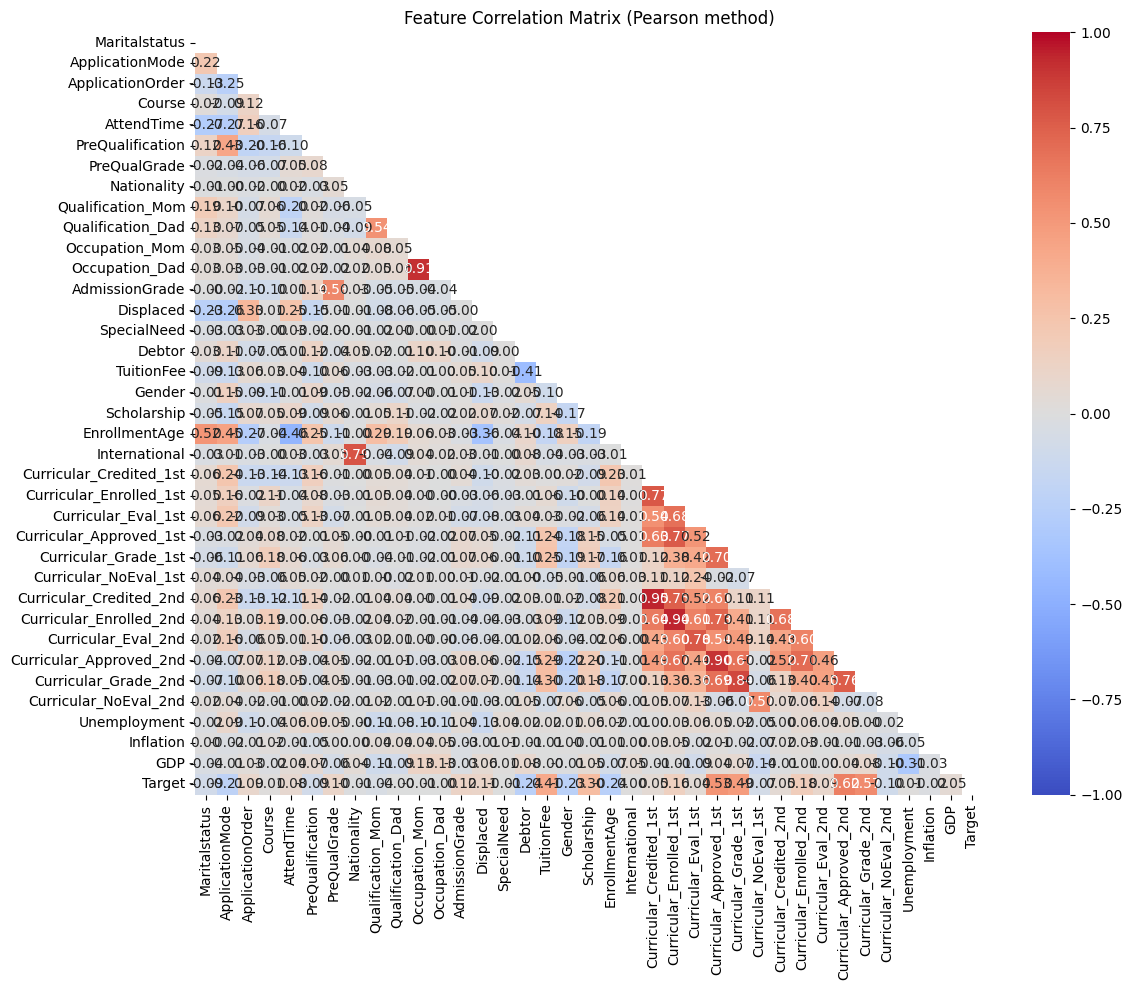

Identified proxy features: {'International': ['Nationality']}


In [5]:
pp.correlation_matrix(df_enc)
proxy_dict = pp.identify_proxy_variables(df_enc, sensitive_attrs=[sensitive_col], method='absolute')
print("Identified proxy features:", proxy_dict)

### Proxy Variable Plots

After identifying `Nationality` as a potential proxy variable, its correlation to the sensitive variable, `International`, will be verified. From the plot, one can see that the distribution of `Nationality` is aligned with the sensitive feature and may encode information related to `International`.

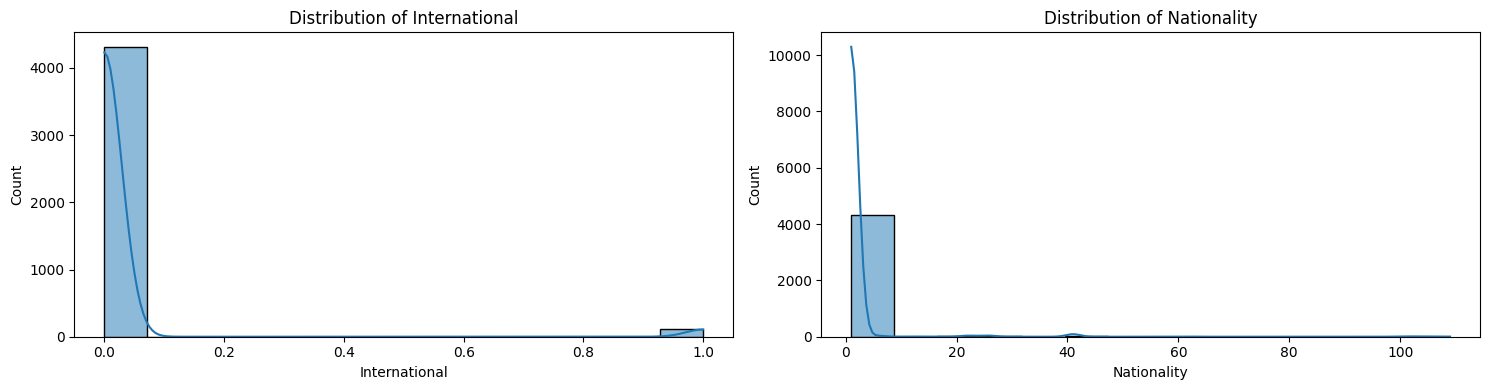

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for ax, col in zip(axes, [sensitive_col, 'Nationality']):
    sns.histplot(df_enc[col], ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout(); plt.show()

### Proxy Modeling

Proxy modeling involves training a predictive model to determine whether certain features can be used to infer a sensitive attribute. If the model achieves high accuracy, it suggests that these features encode information about the sensitive attribute, even if indirectly.

`Nationality` is directly related to `International` as it provides information on country of origin. As such, it cannot be debiased or used without introducing sensitive information. This relationship can be proven using proxy modeling.

Proxy modeling is a strong indicator of potential bias. In this scenario, a logistic regression model is used to predict `International` with only `Nationality`. Since `International` is an ordinal variable with 2 categories, random guessing would yield an expected accuracy of ~50.0%. The model achieved a staggering accuracy of 99.9% and AUC of 1, which reinforces practical knowledge that `Nationality` is almost perfectly collinear with `International` and therefore a direct proxy.

In [7]:
remove_features = 'Nationality'

df_proxy =  df_enc[[remove_features, sensitive_col]]

X_proxy = df_proxy[[remove_features]]
y_proxy = df_proxy[sensitive_col]
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(X_proxy, y_proxy, test_size=0.2, random_state=42)

proxy_model = LogisticRegression(max_iter=1000, random_state=42)
proxy_model.fit(X_train_proxy, y_train_proxy)

y_pred_proxy = proxy_model.predict(X_test_proxy)
y_pred_proba = proxy_model.predict_proba(X_test_proxy)[:, 1]
print(f"Proxy Model Accuracy: {accuracy_score(y_test_proxy, y_pred_proxy):.3f}")
print(f"Proxy Model AUC: {roc_auc_score(y_test_proxy, y_pred_proba):.3f}")

Proxy Model Accuracy: 0.999
Proxy Model AUC: 1.000


## Baseline Model

To establish a performance benchmark, a baseline supervised classifier is trained using all features, including sensitive attribute `International` and proxy feature `Nationality`. The baseline quantifies the model’s unconstrained behavior and exposes any initial disparities. These baseline numbers define the reference point for measuring the effect of later mitigation strategies.

In [8]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Baseline Accuracy Evaluation

After training the baseline logistic regression model, its performance is evaluated using accuracy and ROC AUC. Accuracy measures the proportion of correct predictions, while ROC AUC reflects the model's ability to distinguish between classes across different thresholds.

The baseline model achieves a good overall accuracy (77.3%) and ROC AUC (0.790), indicating proficient model performance in binary classification.

In [9]:
y_pred = baseline_model.predict(X_test)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.773
ROC AUC: 0.790


### Baseline Fairness Evaluation

To assess fairness in the baseline model, the selection rate across groups defined by the sensitive attribute `International` is examined. In this case, selection rate is the proportion of students predicted to receive a scholarship. Using `MetricFrame`, selection rates are computed separately for each group to visualize the disparity.

This result reveals a stark disparity: domestic students (`International = 0`) have a baseline scholarship selection rate of about 11.8%, while international students (`International = 1`) receive a rate of 0%. In other words, the model never predicts scholarships for international students. Such an imbalance highlights how international status may act as a barrier to opportunity, effectively excluding these students from financial support. If left unaddressed, this bias would reinforce systemic disadvantages for international students in accessing higher education resources.

Baseline Selection Rate by international status:


,Selection Rate
International,
Domestic,0.119351
International,0.000000


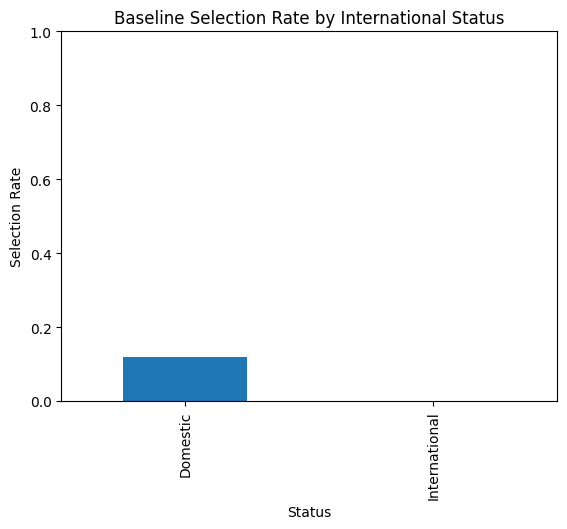

In [10]:
mf_base = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=g_test.replace({0: 'Domestic', 1: 'International'})
)
print("Baseline Selection Rate by international status:")
display(mf_base.by_group)

mf_base.by_group['Selection Rate'].plot(kind='bar')
plt.xlabel('Status'); plt.ylabel('Selection Rate'); plt.title('Baseline Selection Rate by International Status'); plt.ylim(0, 1); plt.show()

## Correlation Remover Model

Most simple bias mitigation techniques only involve removing the sensitive attribute, but more steps are often needed to address indirect bias introduced through proxy features. Correlation removal is a preprocessing fairness technique that works by eliminating correlations between the sensitive attribute and the rest of the dataset to remove indirect encoders of bias. In this case, a `CorrelationRemover` transforms the original dataset to remove correlations with sensitive feature `International`, with `alpha=0.1` indicating that 10% of the correlation is removed. Then, a simple model is fitted to the altered dataset.

In [11]:
cr = CorrelationRemover(sensitive_feature_ids=[sensitive_col], alpha=0.1)
X_features = X.drop(sensitive_col, axis=1)
X_transformed = pd.DataFrame(cr.fit_transform(X), columns=X_features.columns, index=X_features.index)

X_train_debiased, X_test_debiased, y_train_debiased, y_test_debiased, g_train_debiased, g_test_debiased = train_test_split(
    X_transformed, y, g,
    test_size=0.2, random_state=42, stratify=stratify_labels
)

debiased_model = LogisticRegression(max_iter=1000, random_state=42)
debiased_model.fit(X_train_debiased, y_train_debiased)

LogisticRegression(max_iter=1000, random_state=42)

### Correlation Remover Accuracy Evaluation

After training a logistic regression model on the debiased dataset, its performance is evaluated. These results show a slight decrease in performance (77.1% accuracy, 0.788 ROC AUC) compared to the previous model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [12]:
y_pred_deb = debiased_model.predict(X_test_debiased)
y_probs_deb = debiased_model.predict_proba(X_test_debiased)[:, 1]

acc_deb = accuracy_score(y_test_debiased, y_pred_deb)
auc_deb = roc_auc_score(y_test_debiased, y_probs_deb)

print("=== Correlation Remover Model ===")
print(f"Accuracy: {acc_deb:.3f}")
print(f"ROC AUC: {auc_deb:.3f}")

=== Correlation Remover Model ===
Accuracy: 0.771
ROC AUC: 0.788


### Correlation Remover Fairness Evaluation

After removing sensitive correlations, the selection rate across groups defined by the sensitive attribute `International` is examined. In this case, selection rate is the proportion of students predicted to receive a scholarship.

After removing sensitive correlations with `International`, the selection rate for international students receives a nominal increase from 0 to 0.045455. For domestic students, the selection rate only decreases slightly (0.118192), highlighting the capabilities of correlation removal in demographic parity without sacrificing the selection rate of the majority class. Given the initial distribution, this change is great progress toward a more equitable scholarship selection process.

Correlation Removal Selection Rate by international status:


,Selection Rate
International,
Domestic,0.118192
International,0.045455


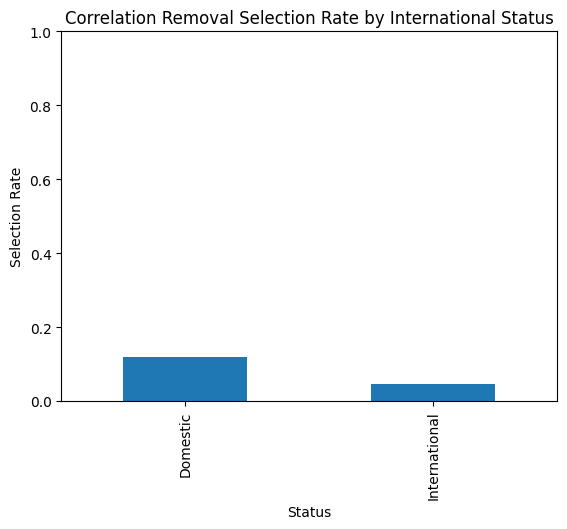

In [13]:
mf_deb = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test_debiased, y_pred=y_pred_deb,
    sensitive_features=g_test_debiased.replace({0: 'Domestic', 1: 'International'})
)
print("Correlation Removal Selection Rate by international status:")
display(mf_deb.by_group)

mf_deb.by_group['Selection Rate'].plot(kind='bar')
plt.xlabel('Status'); plt.ylabel('Selection Rate'); plt.title('Correlation Removal Selection Rate by International Status'); plt.ylim(0, 1); plt.show()

## Exponentiated Gradient Model

To further mitigate bias, this pipeline employs Fairlearn's `ExponentiatedGradient` algorithm with a `DemographicParity` constraint. This method adjusts the model’s predictions to ensure that the selection rate is approximately equal across sensitive groups (in this case, international status), while still aiming to preserve predictive performance.

In [14]:
exg_estimator = LogisticRegression(max_iter=1000, random_state=42)
exg = ExponentiatedGradient(estimator=exg_estimator,
                           constraints=DemographicParity(),
                           eps=0.001)

exg.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x00000197C7CE7DD0>,
                      eps=0.001,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.003506646221705179)

### Exponentiated Gradient Accuracy Evaluation

Exponentiated gradient is combined with proxy debiasing, and a new logistic regression model is evaluated. These results show a decrease in performance (76.6% accuracy, 0.606 ROC AUC), indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [15]:
pmf = exg._pmf_predict(X_test_debiased)
y_prob_exg = pmf @ np.array([0, 1])
y_pred_exg = (y_prob_exg >= 0.5).astype(int)

acc_exg = accuracy_score(y_test_debiased, y_pred_exg)
auc_exg = roc_auc_score(y_test_debiased, y_prob_exg)

print("=== Exponentiated Gradient Model ===")
print(f"Accuracy: {acc_exg:.3f}")
print(f"ROC AUC: {auc_exg:.3f}")

=== Exponentiated Gradient Model ===
Accuracy: 0.766
ROC AUC: 0.606


### Exponentiated Gradient Model Fairness Evaluation

After training the new model, the selection rate across groups defined by the sensitive attribute `International` is examined. In this case, selection rate is the proportion of students predicted to receive a scholarship.

By combining exponentiated gradient with correlation removal, the selection rate for international students starkly increases to 0.272727; at the same time, the selection rate for domestic students only slightly decreases to 0.117034. While this demonstrates a substantial improvement in equity across groups by greatly elevating scholarship chances for international students without sacrificing domestic students, this imbalance may indicate that the model is not allocating scholarships responsibly. Ideally, the selection rates for both student groups would be about equal and maintain responsible scholarship allocation. 

Exponentiated Gradient Selection Rate by international status:


,Selection Rate
International,
Domestic,0.117034
International,0.272727


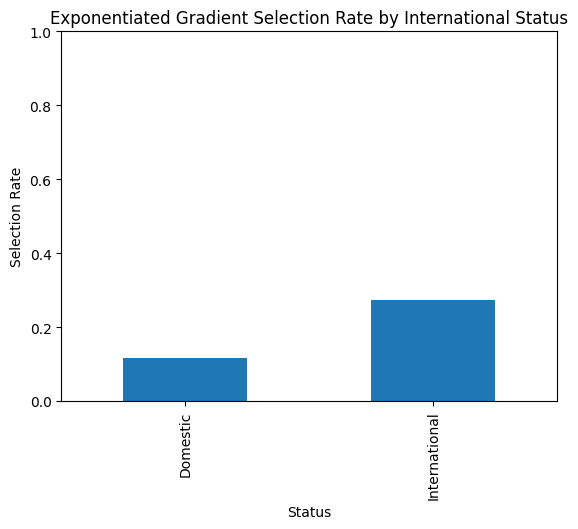

In [16]:
mf_exg = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test_debiased, y_pred=y_pred_exg,
    sensitive_features=g_test_debiased.replace({0: 'Domestic', 1: 'International'})
)
print("Exponentiated Gradient Selection Rate by international status:")
display(mf_exg.by_group)

mf_exg.by_group['Selection Rate'].plot(kind='bar')
plt.xlabel('Status'); plt.ylabel('Selection Rate'); plt.title('Exponentiated Gradient Selection Rate by International Status'); plt.ylim(0, 1); plt.show()

## Threshold Optimizer Model

Another technique for addressing fairness disparities is threshold optimization, which adjusts the decision thresholds of a previously biased model to satisfy a fairness constraint. In this case, the initial baseline model is further refined using the `ThresholdOptimizer` with a demographic parity constraint. This approach modifies the decision thresholds for different sensitive groups, ensuring that selection rates are more evenly distributed across groups (in this case, international status), while still maintaining overall predictive performance.

In [17]:
thresh_estimator = LogisticRegression(max_iter=1000, random_state=42)
thresh = ThresholdOptimizer(
    estimator=thresh_estimator,
    constraints="demographic_parity",
    prefit=False,
    predict_method='predict_proba'
)
thresh.fit(X_train.drop(columns=[sensitive_col], axis=1), y_train, sensitive_features=g_train)

ThresholdOptimizer(estimator=LogisticRegression(max_iter=1000, random_state=42),
                   predict_method='predict_proba')

### Threshold Optimizer Model Accuracy Evaluation

Threshold optimization is used on the baseline model and evaluated for performance. These results show a decrease in performance (76.7% accuracy, 0.609 ROC AUC) compared to the baseline model, indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [18]:
y_pred_thr = thresh.predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test, random_state=42)
y_prob_thr = thresh._pmf_predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test) @ np.array([0,1])

acc_thr = accuracy_score(y_test, y_pred_thr)
auc_thr = roc_auc_score(y_test, y_prob_thr)

print("=== Threshold Optimizer Model ===")
print(f"Accuracy: {acc_thr:.3f}")
print(f"ROC AUC: {auc_thr:.3f}")

=== Threshold Optimizer Model ===
Accuracy: 0.767
ROC AUC: 0.609


### Threshold Optimizer Model Fairness Evaluation

After training the new model, the selection rate across groups defined by the sensitive attribute `International` is examined. In this case, selection rate is the proportion of students predicted to receive a scholarship.

Compared to the baseline, threshold optimizing increases selection rates for international students significantly (0.090909), bringing it in line with selection rates for domestic students (0.132097). This adjustment significantly reduces disparity between groups, demonstrating how threshold-based fairness interventions can promote equity while maintaining overall selection patterns. This distribution balances the selection rates for both student groups and maintains responsible scholarship allocation. 

Threshold Optimizer Selection Rate by international status:


,Selection Rate
International,
Domestic,0.132097
International,0.090909


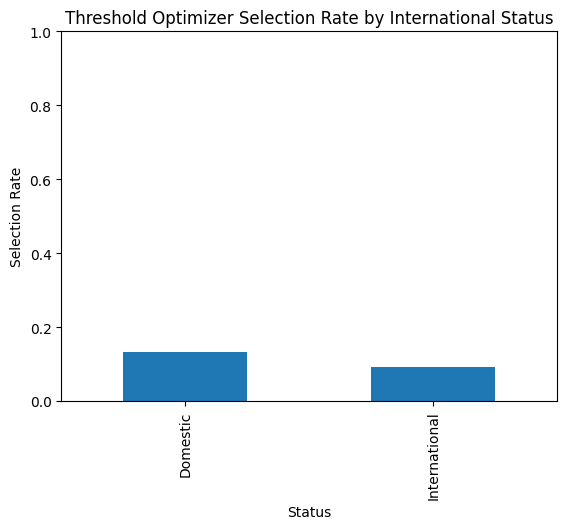

In [19]:
mf_thr = MetricFrame(
    metrics={'Selection Rate': selection_rate},
    y_true=y_test, y_pred=y_pred_thr,
    sensitive_features=g_test.replace({0: 'Domestic', 1: 'International'})
)
print("Threshold Optimizer Selection Rate by international status:")
display(mf_thr.by_group)

mf_thr.by_group['Selection Rate'].plot(kind='bar')
plt.xlabel('Status'); plt.ylabel('Selection Rate'); plt.title('Threshold Optimizer Selection Rate by International Status'); plt.ylim(0, 1); plt.show()

## Model Evaluation

To evaluate the overall impact of fairness interventions, models are compared on three key dimensions: accuracy, ROC AUC, and equalized odds by age group. From the histogram plots, the relative differences across approaches are exposed.

Taken together, theses results show how fairness interventions can narrow disparities and enable equitable access to scholarships. Exponentiated gradient produces the strongest improvement in fairness but at the sharpest decline in discriminative ability. Threshold optimization, in contrast, provides the best compromise: maintaining near-baseline accuracy while meaningfully improving international student inclusion. In scholarship allocation, where both equity and reliability are vital, post-processing adjustments may offer the most practical path forward.

### Accuracy Rate Plots

The baseline scholarship model achieves an accuracy of 77.3%. Correlation removal and threshold optimization maintain comparable performance (77.1% and 76.7%, respectively), while exponentiated gradient reduces performance slightly to 76.6%. This suggests that in-processing fairness constraints impose a greater cost on predictive performance than either pre- or post-processing adjustments.

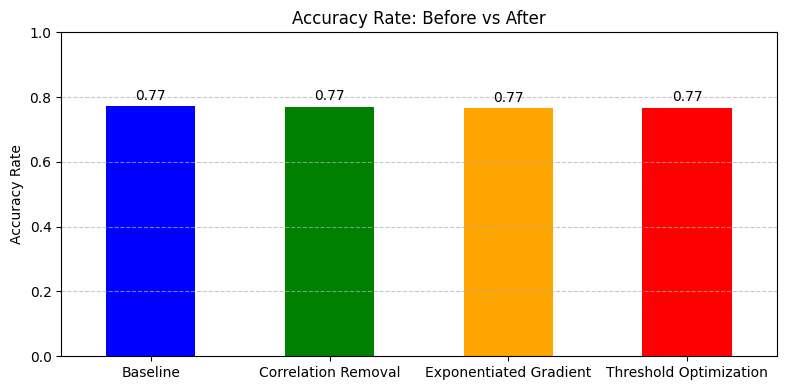

In [20]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_deb, acc_exg, acc_thr]
}, index=['Baseline', 'Correlation Removal', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'green', 'orange', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plots

The baseline model reaches an AUC of 0.790, reflecting good discriminative ability. Correlation removal has little effect (0.788), while exponentiated gradient lowers performance substantially to 0.606. Threshold optimization performs similarly at 0.609. These results highlight that fairness interventions, especially in-processing and post-processing, reduce the model’s ability to rank applicants effectively.

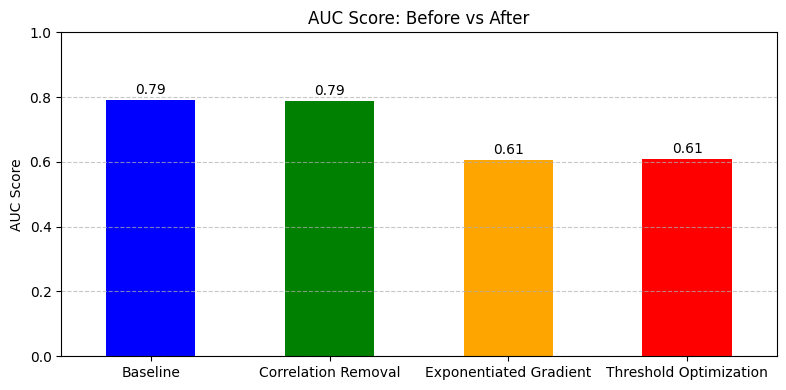

In [21]:
auc_comparison = pd.DataFrame({
    'AUC Rate': [auc, auc_deb, auc_exg, auc_thr]
}, index=['Baseline', 'Correlation Removal', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'green', 'orange', 'red']
auc_series = auc_comparison['AUC Rate']

ax = auc_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('AUC Score'); plt.title('AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Selection Rate Plots

The baseline model entirely excludes international students from scholarships (0.0% selection rate) while awarding domestic students at 11.9%. Correlation removal improves equity only marginally, but exponentiated gradient greatly increases international student selection to 27.3%, narrowing the disparity though at a high cost to AUC. Threshold optimization achieves a more balanced outcome, raising international selection to 9.1% compared to 13.2% for domestic students, substantially reducing exclusion while preserving performance closer to baseline.

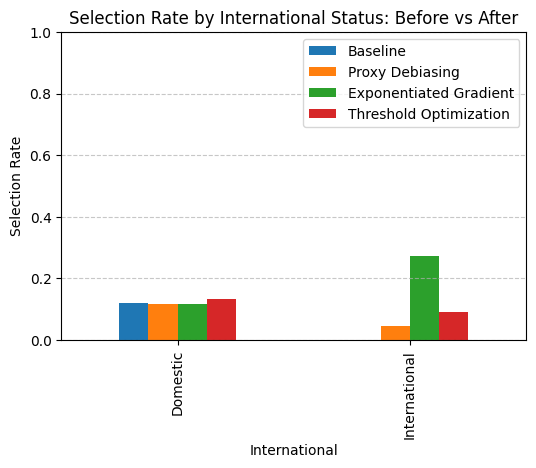

In [22]:
fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['Selection Rate'],
    'Proxy Debiasing': mf_deb.by_group['Selection Rate'],
    'Exponentiated Gradient': mf_exg.by_group['Selection Rate'],
    'Threshold Optimization': mf_thr.by_group['Selection Rate']
})
fairness_comparison.plot(kind='bar', figsize=(6,4))
plt.ylabel('Selection Rate'); plt.title('Selection Rate by International Status: Before vs After'); plt.ylim(0,1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

## Takeaways

This notebook demonstrated how fairness interventions can alter both the accuracy and equity of scholarship allocation models. By comparing correlation removal, exponentiated gradient, and threshold optimization, the pipeline showed how different fairness strategies affect predictive utility and group-level selection rates. Exponentiated gradient achieved the strongest increase in international student inclusion but introduced a severe decline in ROC AUC, limiting its reliability. Threshold optimization, on the other hand, preserved baseline accuracy while substantially narrowing disparities between domestic and international students, making it a more balanced approach.

Fairness does not come without trade-offs: stronger interventions can improve equity but often at the expense of discriminative performance. In educational funding contexts, these trade-offs must be weighed carefully. A model that reduces disparities in scholarship allocation ensures that international students are not systematically excluded from financial opportunities, even if some efficiency is lost. By situating fairness metrics alongside traditional performance measures, this workflow shows how practitioners can design allocation systems that are accurate, equitable, and responsible.